In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T
from tqdm import tqdm
from flow_models.PatchNrFlowModel import PatchNrFlowModel
from img_utils import ImageLoader
from regularisers import PatchNrRegulariser
from transforms import image_normalization

In [17]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


In [18]:
patch_size = 6

In [19]:
neu_model = PatchNrFlowModel('patchNR/patchNR_weights/weights_material.pth', device=DEVICE)

5 512 36


In [20]:
regularizer = PatchNrRegulariser(neu_model, p_size=patch_size, sample_number=50000, device=DEVICE)

In [21]:
def get_ref_values(image, regularizer, sigma=np.linspace(0,5, 40), device='cpu'):
    regularizer_values = []
    mu = 0
    c, h, w = image.shape
    for i in tqdm(sigma):
        noise_vector = normalization(torch.reshape(torch.tensor(np.random.normal(mu, i, h*w), dtype=torch.float, device=device), (1, w, h)))
        img = image + noise_vector
        reg_value = regularizer.evaluate(img)
        regularizer_values.append(reg_value.item())
    return regularizer_values


In [22]:
normalization = T.Compose([image_normalization()])

In [23]:
image_loader = ImageLoader('data/material_pt_nr/testset_superres', device=DEVICE, transform=normalization)

In [24]:
x = np.linspace(0, 30, 40)

In [25]:
values = []
for i in range(30):
    values.append(get_ref_values(image_loader[i].to(DEVICE), regularizer, x, device=DEVICE))

100%|██████████| 40/40 [00:04<00:00,  8.86it/s]


In [26]:
values_npy = np.array(values)

In [27]:
np.save('results/regulariser_eval/noise_sensitivity.npy', values)

In [28]:
loaded_values =np.load('results/regulariser_eval/noise_sensitivity.npy')
t_tesor = torch.tensor(loaded_values)
maxes = []
mins = []
means = []
print(t_tesor.shape)
for i in range(len(x)):
    maxes.append(torch.max(t_tesor[:,i]).item())
    mins.append(torch.min(t_tesor[:,i]).item())
    means.append(torch.mean(t_tesor[:,i]).item())

torch.Size([30, 40])


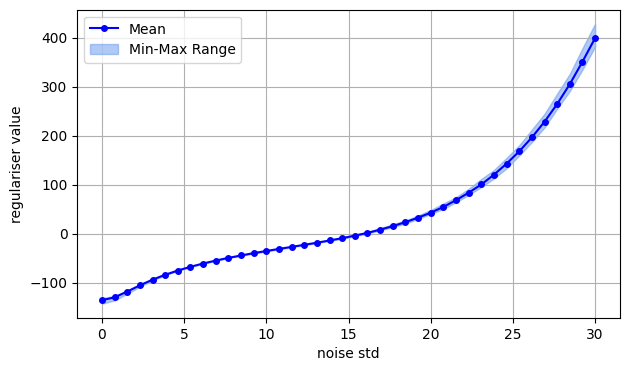

In [29]:
plt.figure(figsize=(7, 4))
plt.plot(x, means, label='Mean', linestyle='-', marker='o', markersize=4, color='blue')
plt.fill_between(x, mins, maxes, color='cornflowerblue', alpha=0.5, label='Min-Max Range')
#plt.plot(x2, means2, label='Mean', linestyle='-', marker='o', markersize=4, color='red')
#plt.fill_between(x2, mins2, maxes2, color='salmon', alpha=0.5, label='Min-Max Range')
#plt.axvline(x = 50000, color = 'g')
plt.legend()
plt.xlabel('noise std')
plt.ylabel('regulariser value')
plt.grid(True)
plt.show()